In [40]:
from sklearn.utils import murmurhash3_32 as mmh3
import numpy as np
import pandas as pd
import networkx as nx
from networkx.algorithms.simple_paths import all_simple_paths as nx_get_paths
from collections import defaultdict 
import random
import time
import math
import sys
from functools import partial
from multiprocessing import Pool

In [6]:
# Enable/disable MULTIPROCESSING
MP_FLAG = False
NUM_PROCS = 3
SEED = 24
random.seed(SEED)

# Read in all bio data
data = pd.read_table("BIOGRID-ORGANISM-Zea_mays-3.5.182.tab2.txt", low_memory = False)
# Extract desired interactions
val = data.copy()
val.set_index("Experimental System Type", inplace = True)
val = val.filter(items = ["Official Symbol Interactor A", "Official Symbol Interactor B", "Pubmed ID"])
val = val.filter(like = "genetic", axis = 0)
# Create graph of these interactions
# graph = nx.from_pandas_edgelist(val, "Official Symbol Interactor A", "Official Symbol Interactor B", create_using=nx.DiGraph)

In [3]:
# Helper functions
def subgraphs_n(graph):
    """
    Returns dictionary of keys corresponding to number of nodes and values 
    corresponding to list of connected subgraphs in graph with that many nodes
    
    graph is a networkx graph
    """
    subgraphs = list(nx.weakly_connected_component_subgraphs(graph))
    subgraphs_n = defaultdict(list)
    for subgraph in subgraphs:
        subgraphs_n[nx.number_of_nodes(subgraph)].append(subgraph)
    return subgraphs_n

def attributes(x):
    """
    Returns "number of source nodes, number of outgoing edges per node..." 
    all concatenated which is equivalent to d(x, 0) for connectivity matrix x
    
    x is a pandas dataframe of connectivity matrix
    """
    n = len(x)
    
    # Initialize with counter of source nodes
    result = [0]
    
    # Increment counter for number of source nodes
    for j in range(n):
        for i in range(n):
            if x.iloc[i,j] != 0:
                break
            elif i == n - 1:
                result[0] += 1
    result[0] = str(result[0])
    # Append sorted list of number of outgoing edges per node
    result.extend(sorted([str(int(sum(x.iloc[i]))) for i in range(n)]))
    result_string = "".join(result)
    return result_string

def subgraph_hash(subgraphs_n, n, r):
    """
    subgraphs_n is the dictionary of number of nodes and lists of subgraphs with
    that many nodes
    n is size of subgraph we are hashing for
    r is measurement of similarity (in paper). As r goes down, we are being more accurate.
    """
    # Start measuring time taken for this hashing method
    start_time = time.time()
    random.seed(24)
    # Sample from n + 1 - r positions of the hash
    positions = sorted(random.sample(range(n + 1), n + 1 - r))
#     print(positions)
    # Initialize hash table
    table = defaultdict(list)
    # For each subgraph of size n
    for subgraph in subgraphs_n[n]:
        # Get the hash "number of source nodes, number of outgoing edges per node..." 
        characteristics = attributes(nx.to_pandas_adjacency(subgraph))
        hash_key = []
        # Sample n + 1 - r positions of the hash
        for p in positions:
            hash_key.append(characteristics[p])
        hash_key_string = "".join(hash_key)
        # Add subgraph to that key in the hash table
        table[hash_key_string].append(subgraph)
    # Stop timing
    end_time = time.time()
#     print(str(n) + ": " + str(end_time - start_time))
#     print(sys.getsizeof(table))
#     return {"subgraph size": n, "hashtable": table, "time":end_time - start_time}
    return {"subgraph size": n, "number subgraphs": len(subgraphs_n[n]),"time":end_time - start_time}

def total_hash(graph, n, r):
    """
    graph is the total graph
    n is size of subgraph we are hashing for
    r is measurement of similarity (in paper). As r goes down, we are being more accurate.
    """
    # Get all the subgraphs categorized into different sizes
    sgn = subgraphs_n(graph)
    # Print how many graphs there are of size 3, 4, 5, 6
    print(len(sgn[3]), len(sgn[4]), len(sgn[5]), len(sgn[6]))
    # Hash subgraphs of size n with similarity level r
    return subgraph_hash(sgn, n, r)
#     print(table)    

In [4]:
# Uniform means that I want to make the number of subgraphs of 
# size 3, 4, 5, 6 the same so that it is not the number of subgraphs
# themselves that affect memory or time taken

# This is necessary for our graphs to be valid!!!
def subgraphs_n_uniform(graph):
    subgraphs = list(nx.weakly_connected_component_subgraphs(graph))
    subgraphs_n = defaultdict(list)
    for subgraph in subgraphs:
        subgraphs_n[nx.number_of_nodes(subgraph)].append(subgraph)
    # Get the minimum count of subgraphs of size 3, 4, 5, 6
    count = min(len(subgraphs_n[3]), len(subgraphs_n[4]), len(subgraphs_n[5]), len(subgraphs_n[6]))
    # Sample that number of subgraphs for each size so now they all have the same number of subgraphs
    for i in range(3, 7):
        subgraphs_n[i] = random.sample(subgraphs_n[i], count)
    return subgraphs_n
# total_hash_uniform is just using subgraphs_n_uniform instead now
def total_hash_uniform(graph, n, r):
    sgn = subgraphs_n_uniform(graph)
#     print(len(sgn[3]), len(sgn[4]), len(sgn[5]), len(sgn[6]))
    return subgraph_hash(sgn, n, r)

In [11]:
# TODO: 0) Create big graphs with a lottt of subgraphs!!! 
# (this allows time measurements and memory measurements to be less affected by random error)
graph_1 = nx.fast_gnp_random_graph(100000, 0.000003, seed=SEED, directed=True)
graph_2 = nx.fast_gnp_random_graph(500000, 0.0000004, seed=SEED, directed=True)
graph_3 = nx.fast_gnp_random_graph(1000000, 0.00000035, seed=SEED, directed=True)
graphs = [(graph_1, 1), (graph_2, 2), (graph_3, 3)]
results = {}
r_val = 3

def pfunc(x, graph, r):
    return total_hash_uniform(graph, x, r)

start = time.time()
if MP_FLAG:
    with Pool(NUM_PROCS) as p:
        for g, g_idx in graphs:
            part_func = partial(pfunc, graph = g)
            res = p.map(part_func, range(3,7))
            results[g_idx] = res
            for r in res:
                print(r["subgraph size"], r["time"])
else:
    print("normal processing")
    # Generate a random graph of size 100000, probability of edge 0.000003.
    for g, g_idx in graphs:
        results[g_idx] = []
        for n in range(3, 7):
            res = pfunc(n, g, int(math.ceil(n*1.0/2)))
#             res = pfunc(n, g, r_val)
            results[g_idx].append(res)
            print(res["subgraph size"], res["time"])

    # First line printed is number of subgraphs size 3, 4, 5, 6. Should be equal for total_hash_uniform.
    # Next line is "number of nodes: time taken to hash subgraphs of that many nodes"
    # Next line is how much memory is used in the hash table (this doesn't change a lot
    # so we should use larger graphs to show the change
end = time.time()
end-start

normal processing
3 0.5771591663360596
4 0.7080316543579102
5 0.8330991268157959
6 0.9665215015411377
3 1.2168185710906982
4 1.4739034175872803
5 1.7530875205993652
6 2.015596628189087
3 6.629467010498047
4 8.005645513534546
5 9.465360879898071
6 11.094065189361572


424.0009460449219

In [21]:
for res in results:
    print(results[res])

[{'subgraph size': 3, 'number subgraphs': 395, 'time': 0.3840365409851074}, {'subgraph size': 4, 'number subgraphs': 395, 'time': 0.4845714569091797}, {'subgraph size': 5, 'number subgraphs': 395, 'time': 0.7556846141815186}, {'subgraph size': 6, 'number subgraphs': 395, 'time': 0.8066411018371582}]
[{'subgraph size': 3, 'number subgraphs': 824, 'time': 0.8514454364776611}, {'subgraph size': 4, 'number subgraphs': 824, 'time': 1.108386516571045}, {'subgraph size': 5, 'number subgraphs': 824, 'time': 1.1589741706848145}, {'subgraph size': 6, 'number subgraphs': 824, 'time': 1.4212677478790283}]
[{'subgraph size': 3, 'number subgraphs': 4514, 'time': 5.358015060424805}, {'subgraph size': 4, 'number subgraphs': 4514, 'time': 7.172184467315674}, {'subgraph size': 5, 'number subgraphs': 4514, 'time': 6.235709190368652}, {'subgraph size': 6, 'number subgraphs': 4514, 'time': 7.516926050186157}]


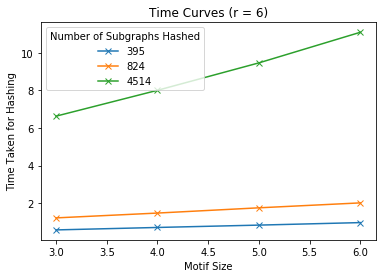

In [12]:
import matplotlib.pyplot as plt
def time_curve(times, sizes):            
    colors = ['b', 'r', 'g', 'c', 'm', 'y', 'k']
    plt.figure()
    for i in range(len(sizes)):
        plt.plot([3, 4, 5, 6], times[i], colors[i], marker = "x")
    plt.title("Time Curves")
    plt.xlabel("Motif Size")
    plt.ylabel("Time Taken for Hashing")
    plt.legend(sizes, loc="upper left", title="Number of Subgraphs Hashed")
    plt.show()
# I know this looks hard code-y but these were the numbers I got in my first run.
for res in results:
    times = [r['time'] for r in results[res]]
    sizes = [r['subgraph size'] for r in results[res]]
    num_subgraphs = results[res][0]['number subgraphs']
    plt.plot(sizes, times, marker = "x", label = num_subgraphs)
#     plt.title("Time Curves (r = "+str(r_val)+")")
    plt.title("Time Curves")
    plt.xlabel("Motif Size")
    plt.ylabel("Time Taken for Hashing")
    #     plt.show()
plt.legend(loc="upper left", title="Number of Subgraphs Hashed")

# time_curve([[0.5374, 0.6214, 0.6779, 0.8459]], [395])
# time_curve([[1.2100, 1.3620, 1.5745, 1.8273]], [824])
# time_curve([[5.4358, 7.3154, 8.1447, 8.9011]], [4514])
# time_curve([[0.5374, 0.6214, 0.6779, 0.8459], [1.2100, 1.3620, 1.5745, 1.8273], [5.4358, 7.3154, 8.1447, 8.9011]], [395, 824, 4514])

In [ ]:
# TODO: 1) Time curves - create time curves for more number of subgraphs (not just 395, 824, 2514)

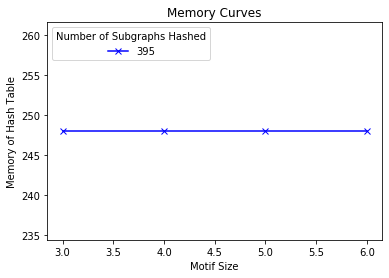

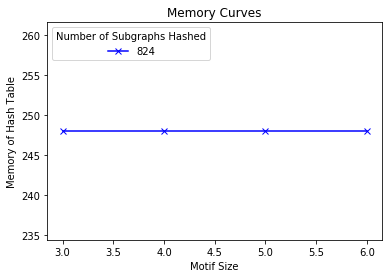

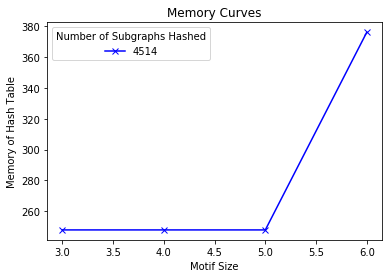

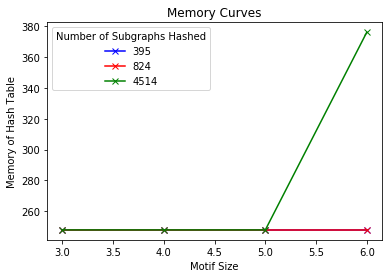

In [6]:
def memory_curve(mems, sizes):            
    colors = ['b', 'r', 'g', 'c', 'm', 'y', 'k']
    plt.figure()
    for i in range(len(sizes)):
        plt.plot([3, 4, 5, 6], mems[i], colors[i], marker = "x")
    plt.title("Memory Curves")
    plt.xlabel("Motif Size")
    plt.ylabel("Memory of Hash Table")
    plt.legend(sizes, loc="upper left", title="Number of Subgraphs Hashed")
    plt.show()
memory_curve([[248, 248, 248, 248]], [395])
memory_curve([[248, 248, 248, 248]], [824])
memory_curve([[248, 248, 248, 376]], [4514])
memory_curve([[248, 248, 248, 248], [248, 248, 248, 248], [248, 248, 248, 376]], [395, 824, 4514])

In [ ]:
# TODO: 2) Memory curves - make a memory curve for super big graphs that 
# have way more subgraphs per size than just 2514 because this will hopefully 
# show a progression in the memory. Right now, because of how dictionaries are 
# implemented in Python, the change doesn’t look legit.

In [571]:
# TODO: 3) Create a new distance metric
# NGL IDK HOW TO CHANGE THIS 
def attributes_improved(x):
    """
    Returns [number of source nodes, number of outgoing edges per node...]
    which is equivalent to d(x, 0) for connectivity matrix x
    
    x is a pandas dataframe
    """
    # This is the old implementation
#     n = len(x)
    
#     # Initialize with counter of source nodes
#     result = [0]
    
#     # Increment counter for number of source nodes
#     for j in range(n):
#         for i in range(n):
#             if x.iloc[i,j] != 0:
#                 break
#             elif i == n - 1:
#                 result[0] += 1
#     result[0] = str(result[0])
#     # Append sorted list of number of outgoing edges per node
#     result.extend(sorted([str(int(sum(x.iloc[i]))) for i in range(n)]))
#     result_string = "".join(result)
#     return result_string

# Uses attributes_improved instead (don't need to change this)
def subgraph_hash_improved(subgraphs_n, n, r):
    """
    n is size of subgraph
    r is measurement of similarity (in paper)
    """
    start_time = time.time()
    random.seed(24)
    positions = sorted(random.sample(range(n + 1), n + 1 - r))
#     print(positions)
    table = defaultdict(list)
    for subgraph in subgraphs_n[n]:
        characteristics = attributes_improved(nx.to_pandas_adjacency(subgraph))
        hash_key = []
        for p in positions:
            hash_key.append(characteristics[p])
        hash_key_string = "".join(hash_key)
        table[hash_key_string].append(subgraph)
    print(str(n) + ": " + str(time.time() - start_time))
    print(sys.getsizeof(table))
    
# Uses subgraph_hash_improved instead (don't need to change this)
def total_hash_uniform_improved(graph, n, r):
    sgn = subgraphs_n_uniform(graph)
    print(len(sgn[3]), len(sgn[4]), len(sgn[5]), len(sgn[6]))
    subgraph_hash_improved(sgn, n, r)

In [572]:
# TODO: 4) Get the run times of hashing with this new distance metric to compare 
# it with the hashing in Legault’s paper. To get a better run time, the distance 
# metric should require less processing so honestly we could just make a really 
# shitty distance metric to get a really good run time.
graph_1 = nx.fast_gnp_random_graph(100000, 0.000003, seed=24, directed=True)
graph_3 = nx.fast_gnp_random_graph(1000000, 0.00000035, seed=24, directed=True)
graph_2 = nx.fast_gnp_random_graph(500000, 0.0000004, seed=24, directed=True)
for graph in [graph_1, graph_3, graph_2]:
    for n in range(3, 7):
        total_hash_uniform_improved(graph_2, n, int(math.ceil(n*1.0/2)))

824 824 824 824
3: 1.1406357288360596
248
824 824 824 824
4: 1.2556853294372559
248
824 824 824 824
5: 1.4479517936706543
248
824 824 824 824
6: 1.6135149002075195
248


In [ ]:
# TODO: 5) Show the tradeoff between run time and accuracy by enumerating cases
# in bio data where we are grouping subgraphs that are very different.

# Minhash Fingerprinting

Relevant papers: 
https://www.researchgate.net/publication/325439143_Min-Hash_Fingerprints_for_Graph_Kernels_A_Trade-off_among_Accuracy_Efficiency_and_Compression

http://cscubs.cs.uni-bonn.de/2016/proceedings/paper-07.pdf

1. Extract substructures from subgraph ie. paths
2. Map substructures to ints and collect into a set
3. Apply k minhash function to this set to get k hashes
4. The fingerprint is the set of k hashes
5. With this compressed graph representation, group all graphs based on simple hash functions

OR

1. Extract substructures from subgraph ie. paths
2. Map substructures to ints and collect into a set
3. Apply SINGLE minhash function


In [71]:
# second simpler way
def get_paths(subgraphs_n, n):
    graphs_as_paths = []
    for subgraph in subgraphs_n[n]:
        graph_paths = []
        for start in subgraph.nodes:
            for end in subgraph.nodes:
                if (start != end):
                    path_set = nx_get_paths(subgraph, start, end)
                    graph_paths.append(path_set)
        graphs_as_paths.append(graph_paths)
    return graphs_as_paths

def vertex_map(node_num, graph):
    return graph.degree[node_num]
# maps a path to an integer
# possible overflow errors
def fingerprint(path, prime, graph):
    product = 1
    for node in path:
        product = product * prime + vertex_map(node, graph)
    return product

# expects array of path generators
def graph_to_int(path_sets, graph):
    int_set = set()
    for gp in path_sets:
        for path in gp:
            int_set.add(fingerprint(path, 31, graph))
    return int_set

def min_hash(int_set, seed, table_size):
    seeded_mmh3 = partial(mmh3, seed = seed)
#     return min(map(seeded_mmh3, int_set)) % table_size
    return min(map(seeded_mmh3, int_set))

def min_hash_table(subgraphs_n, n, table_size):
    graph_paths = get_paths(subgraphs_n, 3)
    table = defaultdict(list)
    for gp, subgraph in zip(graph_paths, subgraphs_n[n]):
        int_set = graph_to_int(gp, subgraph)
        hash_idx = min_hash(int_set, SEED, table_size)
        table[hash_idx].append(subgraph)
    return table
        

In [72]:
graph_1 = nx.fast_gnp_random_graph(100000, 0.000003, seed=SEED, directed=True)
subgraphs_n = subgraphs_n_uniform(graph_1)
table = min_hash_table(subgraphs_n, 3, 200)

In [73]:
table

defaultdict(list,
            {-1939500827: [<networkx.classes.digraph.DiGraph at 0x7f55c91f2450>,
             1449563120: [<networkx.classes.digraph.DiGraph at 0x7f55c9c8b450>,
             417407963: [<networkx.classes.digraph.DiGraph at 0x7f55dc631790>,
              <networkx.classes.digraph.DiGraph at 0x7f55c8f1a890>]})

In [ ]:
# IDEA for meaningful vertices
# relabel so that vertex value is degree